In [1]:
!pip install tensorflow==2.10.0


In [3]:
import tensorflow.keras as keras


In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

11490434/11490434 [==============================] - 0s 0us/step


1/1 [==============================] - 0s 56ms/step


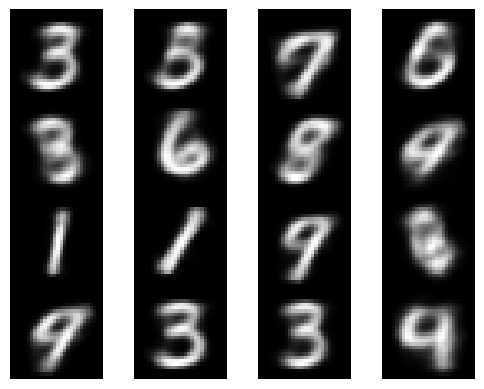

----------- EPOCH 4 -----------
1012/1875 [===============>..............] - ETA: 28s - loss: 0.1981

KeyboardInterrupt: 

In [6]:
# Plot image data from x_train
plt.imshow(x_train[0], cmap = "gray")
plt.show()
LATENT_SIZE = 32
encoder = Sequential([
    Flatten(input_shape = (28, 28)),
    Dense(512),
    LR(),
    Dropout(0.5),
    Dense(256),
    LR(),
    Dropout(0.5),
    Dense(128),
    LR(),
    Dropout(0.5),
    Dense(64),
    LR(),
    Dropout(0.5),
    Dense(LATENT_SIZE),
    LR()
])
decoder = Sequential([
    Dense(64, input_shape = (LATENT_SIZE,)),
    LR(),
    Dropout(0.5),
    Dense(128),
    LR(),
    Dropout(0.5),
    Dense(256),
    LR(),
    Dropout(0.5),
    Dense(512),
    LR(),
    Dropout(0.5),
    Dense(784),
    Activation("sigmoid"),
    Reshape((28, 28))
])
img = Input(shape = (28, 28))
latent_vector = encoder(img)
output = decoder(latent_vector)
model = Model(inputs = img, outputs = output)
model.compile("nadam", loss = "binary_crossentropy")
EPOCHS = 60
#Only do plotting if you have IPython, Jupyter, or using Colab
for epoch in range(EPOCHS):
    fig, axs = plt.subplots(4, 4)
    rand = x_test[np.random.randint(0, 10000, 16)].reshape((4, 4, 1, 28, 28))

    display.clear_output() # If you imported display from IPython

    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(model.predict(rand[i, j])[0], cmap = "gray")
            axs[i, j].axis("off")

    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.show()
    print("-----------", "EPOCH", epoch, "-----------")
    model.fit(x_train, x_train)

Convolutional autoencoder for image denoising

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist
from keras.models import Model

In [11]:
def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

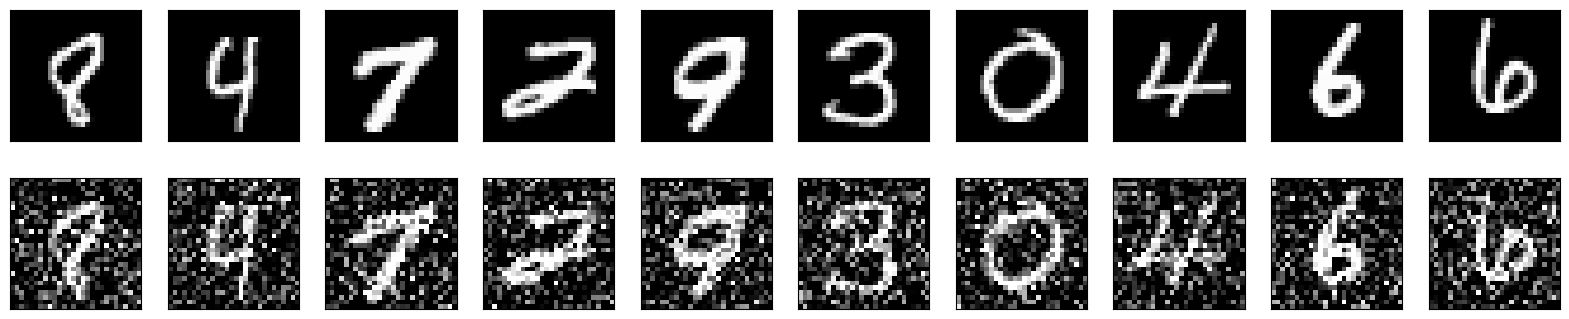

In [12]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [13]:
"""
## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.
"""

input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248

In [15]:
"""
Now we can train our autoencoder using `train_data` as both our input data
and target. Notice we are setting up the validation data using the same
format.
"""

autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 [==============================] - 193s 411ms/step - loss: 0.0679 - val_loss: 0.0671
Epoch 2/50
469/469 [==============================] - 195s 416ms/step - loss: 0.0672 - val_loss: 0.0665
Epoch 3/50
469/469 [==============================] - 191s 406ms/step - loss: 0.0667 - val_loss: 0.0660
Epoch 4/50
469/469 [==============================] - 192s 410ms/step - loss: 0.0662 - val_loss: 0.0656
Epoch 5/50
469/469 [==============================] - 191s 407ms/step - loss: 0.0659 - val_loss: 0.0652
Epoch 6/50
469/469 [==============================] - 196s 419ms/step - loss: 0.0656 - val_loss: 0.0650
Epoch 7/50
469/469 [==============================] - 191s 407ms/step - loss: 0.0653 - val_loss: 0.0648
Epoch 8/50
469/469 [==============================] - 189s 403ms/step - loss: 0.0651 - val_loss: 0.0646
Epoch 9/50
469/469 [==============================] - 188s 402ms/step - loss: 0.0649 - val_loss: 0.0644
Epoch 10/50
469/469 [==============================] - 190s 406m

313/313 [==============================] - 8s 25ms/step


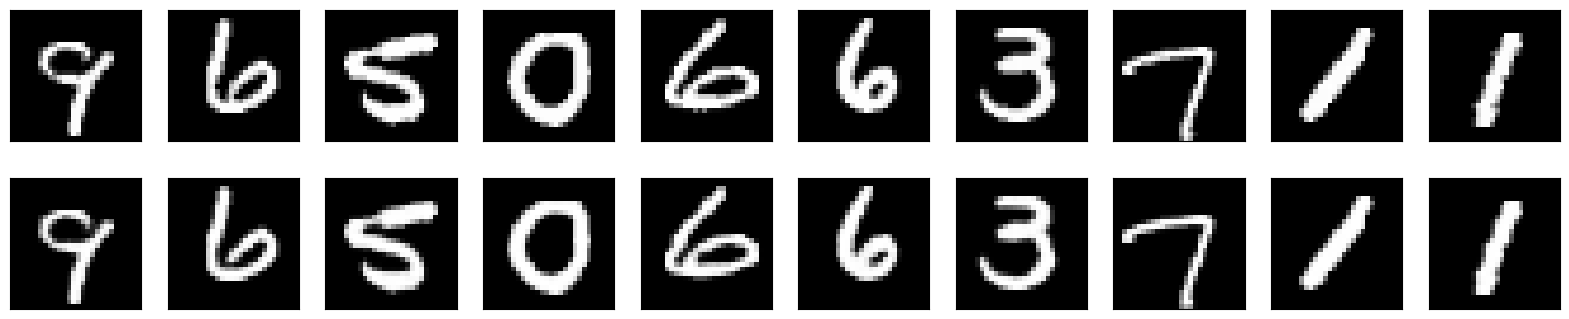

In [17]:

"""
Let's predict on our test dataset and display the original image together with
the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although
not quite the same.
"""

predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [19]:
"""
Now that we know that our autoencoder works, let's retrain it using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.
"""

autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)


Epoch 1/50
469/469 [==============================] - 190s 404ms/step - loss: 0.0966 - val_loss: 0.0932
Epoch 2/50
469/469 [==============================] - 191s 408ms/step - loss: 0.0929 - val_loss: 0.0913
Epoch 3/50
469/469 [==============================] - 192s 410ms/step - loss: 0.0914 - val_loss: 0.0901
Epoch 4/50
469/469 [==============================] - 192s 409ms/step - loss: 0.0905 - val_loss: 0.0894
Epoch 5/50
469/469 [==============================] - 190s 404ms/step - loss: 0.0898 - val_loss: 0.0889
Epoch 6/50
469/469 [==============================] - 190s 405ms/step - loss: 0.0893 - val_loss: 0.0884
Epoch 7/50
469/469 [==============================] - 190s 405ms/step - loss: 0.0889 - val_loss: 0.0882
Epoch 8/50
469/469 [==============================] - 189s 403ms/step - loss: 0.0885 - val_loss: 0.0877
Epoch 9/50
469/469 [==============================] - 192s 409ms/step - loss: 0.0882 - val_loss: 0.0874
Epoch 10/50
469/469 [==============================] - 188s 401m

313/313 [==============================] - 10s 32ms/step


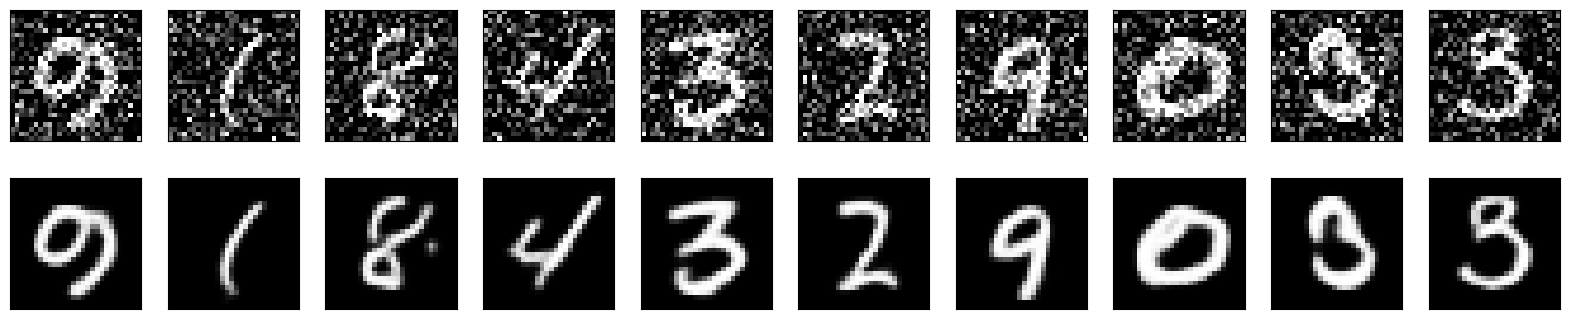

In [20]:
"""
Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.
"""

predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)